This notebook is used to test how the logicle function behaves if just one parameter is changed, to identify the reason for the odd behaviour in the implementation

In [63]:
import pandas as pd
import numpy as np
import sys
import scipy
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

def solve_d (w,b):
    if w==0:
        return b
    def g(x):
        g = w*(b+x)+2*(np.log(x)-np.log(b))
        return g
    d = fsolve(g, b)
    return d

In [69]:
# function to compute linear region width
def compute_W(T, trans, M):
    from scipy.optimize import newton
    h = lambda W: (W/(M-W))-logicleTransform(trans, T=T, W=float(W), M=M)

    W = newton(h,  0.5, tol=1e-10)
    return W

# function to get parameters and print them
def func_param(T, trans=None, M=None, W=None):
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)
    
    A = -W
    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1))
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a 
    parameters = pd.DataFrame({'a': a, 'b': b, 'c': c, 'd': d, 'x0': x0})
    return parameters


In [65]:
def biexponentialTaylorSeries(scaled, T, W, A, M):

    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a
    
    order = 16 # order of taylor series is 16

    posCoef = a*np.exp(b*x1)
    negCoef = -c*np.exp(-d*x1)
    taylorCoef = np.zeros(order)

    for i in range(order):
        posCoef = posCoef*(b/(i+1))
        negCoef = negCoef*(-d/(i+1))
        taylorCoef[i] = posCoef + negCoef
    taylorCoef[1]=0 # ensuring that the second derivative is 0 (logicle condition)    

    x = scaled - x1
    sum = 0

    for i in range(order): 
        sum = (sum + taylorCoef[order-1-i])*x 
        
    return sum

def compute_M(T, trans, W):
    from scipy.optimize import newton
    def f(M):
        return W/logicleTransform(trans, T=T, W=W, M=float(M), A=-W)+W - M
    
    M = newton(f, 3, tol=1e-5, maxiter=100)
    return M

def logicleTransform(par, T, trans=None, W=None, A=None, M=None):
    # set missing parameters
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    # check parameter conditions
    if T <= 0:
    	sys.exit("T is not positive")

    if W < 0:
	    sys.exit("W is negative")

    if M <= 0:
	    sys.exit("M is not positive")

    if 2 * W > M:
	    sys.exit("W is too large")

    if -A > W or A + W > M - W:
	    sys.exit("A is too large")

    # compute parameters for biexponential function
    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a 



    def logicleTransform1d(value):
        if value==0: # exclude exact zero value
            return x1

        negative = value<0
        if negative:
            value = -value
    
        if value < f:
          x = x1+(value/(a*b*np.exp(b*x1)+c*d*np.exp(-d*x1))) # later use taylorCoef[0]?!
    
        if value >= f:
          x = np.log(value/a)/b # in original implementation other condition, why?
    
        tolerance = 1e-10 # set tolerance for convergence
        n_steps = 50 # set maximal number of steps for Halley's method
        taylor_treshold = x1 + w/4 # threshold for neighbourhood of x1 in which we apply taylor series

        for i in range(n_steps):
            step = i
            first_term = a*np.exp(b*x)
            second_term = c*np.exp(-d*x)

            if x < taylor_treshold:
                y = biexponentialTaylorSeries(x,  T, W, A, M) - value
            else:
                y = first_term-second_term+f - value
            dy = b*first_term + d*second_term
            ddy = b*b*first_term - d*d*second_term

            delta = y/(dy-((y*ddy)/(2*dy)))
            x = x - delta

            if np.absolute(delta) < tolerance:
                if negative:
                    return 2*x1-x
                else:
                    return x
                
        sys.exit("Scale did not converge!")
   
    if np.ndim(par)==0:
        logicle_par = logicleTransform1d(par)
    else:
        length = len(par)
        logicle_par = np.zeros(length)

        for i in range(length):
            logicle_par[i] = logicleTransform1d(par[i])
    
    return logicle_par

In [91]:
def logicleInverseTransform(scaled, T, trans=None, W=None, A=None, M=None):
    # set missing parameters
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    # check parameter conditions
    if T <= 0:
    	sys.exit("T is not positive")

    if W < 0:
	    sys.exit("W is negative")

    if M <= 0:
	    sys.exit("M is not positive")

    if 2 * W > M:
	    sys.exit("W is too large")

    if -A > W or A + W > M - W:
	    sys.exit("A is too large")

    # compute parameters for biexponential function
    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a


    def logicleInverseTransform1d(scaled):
        negative = scaled < x1

        if negative:
            scaled = 2*x1-scaled   # reflect negative region
    
        taylor_treshold = x1 + w/4 # threshold for neighbourhood of x1 in which we apply taylor series (include in logicle object?)

        if scaled < taylor_treshold:
            inverse = biexponentialTaylorSeries(scaled, T, W, A, M)
        else:
            inverse = a*np.exp(b*scaled)-c*np.exp(-d*scaled)+f

        if negative:
            return - inverse
        else:
            return inverse


    if np.ndim(scaled)==0:
        inverse = logicleInverseTransform1d(scaled)
    else:
        length = len(scaled)
        inverse = np.zeros(length)

        for i in range(length):
            inverse[i] = logicleInverseTransform1d(scaled[i])

    
    return inverse

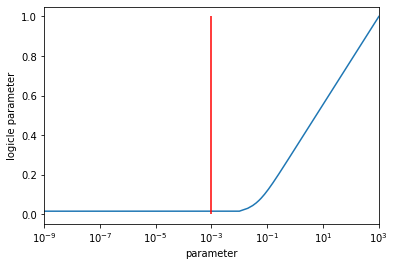

In [86]:
# visual inspection
T = 1000
trans = 1e-3


par = np.linspace(0,1e3,10**5)
logicle_par = logicleTransform(par, T=T, trans=trans) 

# astring=str(func_param(T,trans, M=M).at[0,'a'])
# bstring=str(func_param(T,trans, M=M).at[0,'b'])
# cstring=str(func_param(T,trans, M=M).at[0,'c'])
# dstring=str(func_param(T,trans, M=M).at[0,'d'])
# x0string=str(func_param(T,trans, M=M).at[0, 'x0'])

M =4.5
W = compute_W(T, trans, M)
transition_point = np.array([W/(M-W)])
transition = logicleInverseTransform(transition_point, T, trans, M=M, W=W)

fig = plt.figure()
plt.plot(par, logicle_par)
plt.vlines(transition, 0, 1, color='red', label='transition')
plt.xlabel("parameter")
plt.ylabel("logicle parameter")
plt.xscale('log')
plt.xlim(1e-9,1e3)
# fig.text(0,1,s='a='+astring+'  b='+bstring+'  c='+cstring+'  d='+dstring+'  x0='+x0string)
plt.show()


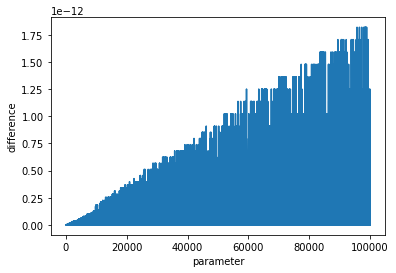

In [92]:
# compute inverse and differences

inv_par_logicle = logicleInverseTransform(scaled=logicle_par, T=T, trans= trans)

diff = np.abs(inv_par_logicle - par)

plt.plot(diff)
plt.xlabel('parameter')
plt.ylabel('difference')
plt.show()